# 1. Data LOAD

In [4]:
import data_loader.yolo_converter as yc

In [5]:
data_converter = yc.YoloDataConverter("D:/dataset/상품 이미지")
data_converter.make_yolo_labels(isTraining=True)
data_converter.make_yolo_labels(isTraining=False)
data_converter.make_data_yaml()

100%|██████████| 15/15 [00:00<00:00, 961.86it/s]


# 2. KFCV
* AI-hub에서 주는 Validation 데이터는 Test 데이터로 쓸 예정
* Train data로 KFCV 수행

In [6]:
import datetime
import shutil
from pathlib import Path
from collections import Counter

import yaml
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_16180\2677345942.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
# 라벨 데이터를 불러옴
dataset_path = Path("D:/dataset/상품 이미지")
labels = sorted(dataset_path.rglob("labels/train/*/*/*.txt"))

In [8]:
# data.yaml에서 클래스 정보를 읽어옴
yaml_file = "D:/dataset/상품 이미지/data.yaml"
with open(yaml_file, 'r', encoding="utf-8") as y:
    classes = yaml.safe_load(y)['names']
cls_idx = [idx for idx in range(0, len(classes))]

In [9]:
# label이름 x 클래스번호 dateframe 생성
indx = [l.stem for l in labels]
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)
labels_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
10060_0_m_10_meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10060_0_m_11_meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10060_0_m_12_meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 각 label을 돌아다니며 클래스번호 세기
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # `nan` -> `0` 대체해주기
labels_df.head(3)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_16180\4073261530.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # `nan` -> `0` 대체해주기


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
10060_0_m_10_meta,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10060_0_m_11_meta,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10060_0_m_12_meta,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2-1. K-폴드 데이터 세트 분할
* `k`: 5로 설정
* `random_state` : 7 → 결과가 고르게 나옴

In [11]:
ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=7)

kfolds = list(kf.split(labels_df))

In [12]:
# 폴드 별 데이터세트 분할
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df.loc[labels_df.iloc[train].index, f'split_{idx}'] = 'train'
    folds_df.loc[labels_df.iloc[val].index, f'split_{idx}'] = 'val'
folds_df.head(1)

,split_1,split_2,split_3,split_4,split_5
10060_0_m_10_meta,val,train,train,train,train


In [13]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)
for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    ratio = val_totals / (train_totals + 1E-7) # 0으로 나누는 에러를 피하려고 작은 값 (1E-7) 추가
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

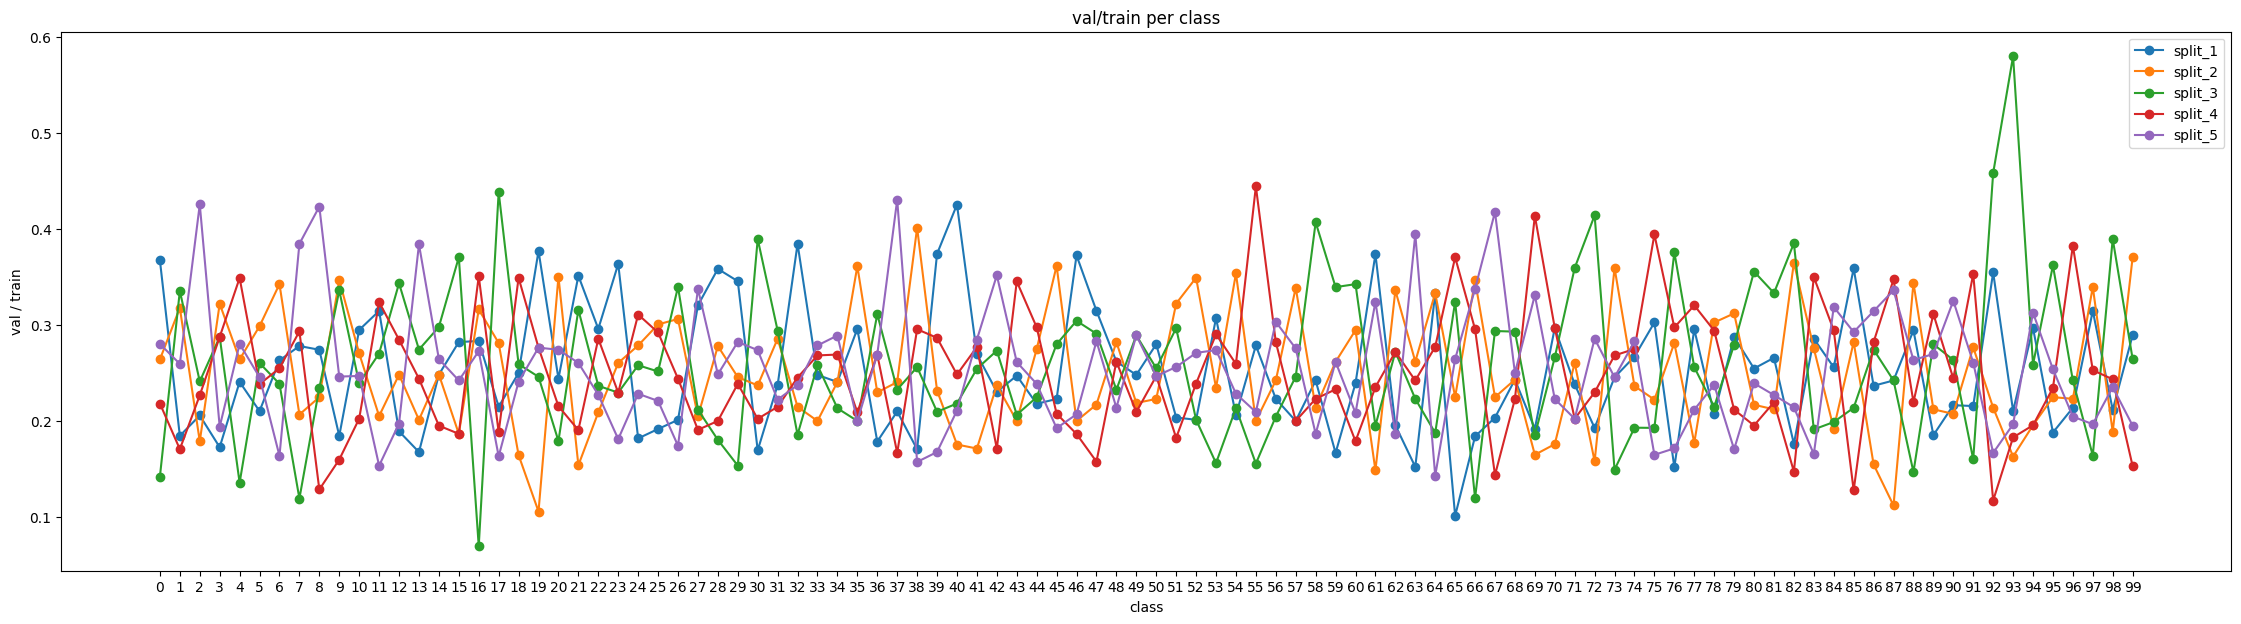

In [14]:
plt.rcParams["figure.figsize"] = (28,7)
plt.xlabel("class")
plt.ylabel("val / train")
plt.title("val/train per class")
plt.xticks(np.arange(0, 100, 1))
for i in range(0, 5):
    plt.plot(cls_idx, fold_lbl_distrb.iloc[i], "-o", label=fold_lbl_distrb.index[i])
plt.legend()

### 2-2. 각 분할에 대한 디렉토리와 yaml 파일 생성

In [15]:
exts = ['.jpg', '.jpeg', '.png']

# 이미지 경로를 저장
images = []
for ext in exts:
    images.extend(sorted((dataset_path / 'images/train').rglob(f"*{ext}")))

# split에 대해서 디릭토리 & yaml 파일을 생성함
save_path = Path(dataset_path / f'{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # dir 생성
    split_dir = save_path / split # ex) ./상품이미지/2024-02-01_5-fold_Cross-val/split_1 
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # yaml 파일 생성
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(), # 현재 경로
            'train': 'train',             # train 경로
            'val': 'val',                 # val 경로
            'names': classes
        }, ds_y)

In [19]:
folds_df.head(3)

,split_1,split_2,split_3,split_4,split_5
10060_0_m_10_meta,val,train,train,train,train
10060_0_m_11_meta,train,train,train,val,train
10060_0_m_12_meta,train,train,train,val,train


In [21]:
# 파일 split 폴더로 복사
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[label.stem].items():
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'
        
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [22]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")